In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Find the most recent date in the data set.
#default of order_by is ascending
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
recent_date

'2017-08-23'

In [20]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

# Perform a query to retrieve the date and precipitation scores
#Using this date (2017-08-23), retrieve the previous 12 months of precipitation data by querying the 12 previous months of data. 
#Note: Do not pass in the date as a variable to your query.

query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
last_year_data = session.query(Measurement).filter(Measurement.date >= query_date).order_by(Measurement.date)
# for date in last_year_data:
#     print(f"{date.date}, {date.prcp}")
measurements_results = [{"Date": result.date, "PRCP": result.prcp} for result in last_year_data]
measurements_results

[{'Date': '2016-08-23', 'PRCP': 0.0},
 {'Date': '2016-08-23', 'PRCP': 0.15},
 {'Date': '2016-08-23', 'PRCP': 0.05},
 {'Date': '2016-08-23', 'PRCP': None},
 {'Date': '2016-08-23', 'PRCP': 0.02},
 {'Date': '2016-08-23', 'PRCP': 1.79},
 {'Date': '2016-08-23', 'PRCP': 0.7},
 {'Date': '2016-08-24', 'PRCP': 0.08},
 {'Date': '2016-08-24', 'PRCP': 2.15},
 {'Date': '2016-08-24', 'PRCP': 2.28},
 {'Date': '2016-08-24', 'PRCP': None},
 {'Date': '2016-08-24', 'PRCP': 1.22},
 {'Date': '2016-08-24', 'PRCP': 2.15},
 {'Date': '2016-08-24', 'PRCP': 1.45},
 {'Date': '2016-08-25', 'PRCP': 0.08},
 {'Date': '2016-08-25', 'PRCP': 0.08},
 {'Date': '2016-08-25', 'PRCP': 0.0},
 {'Date': '2016-08-25', 'PRCP': 0.0},
 {'Date': '2016-08-25', 'PRCP': 0.21},
 {'Date': '2016-08-25', 'PRCP': 0.06},
 {'Date': '2016-08-25', 'PRCP': 0.11},
 {'Date': '2016-08-26', 'PRCP': 0.0},
 {'Date': '2016-08-26', 'PRCP': 0.03},
 {'Date': '2016-08-26', 'PRCP': 0.02},
 {'Date': '2016-08-26', 'PRCP': 0.04},
 {'Date': '2016-08-26', 'PRCP'

In [21]:
# checking that correct number of rows are pulled
last_year_data_count = session.query(Measurement).filter(Measurement.date >= '2016-08-23').count()
print(last_year_data_count)

2230


In [22]:
# Save the query results as a Pandas DataFrame and set the index to the date column
#precip_df = pd.read_sql("SELECT Measurement.date, Measurement.prcp FROM Measurement WHERE Measurement.date >= '2016-08-23'", conn)
precip_df = pd.DataFrame(measurements_results)
precip_df

,Date,PRCP
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02
...,...,...
2225,2017-08-22,0.50
2226,2017-08-23,0.00
2227,2017-08-23,0.00
2228,2017-08-23,0.08


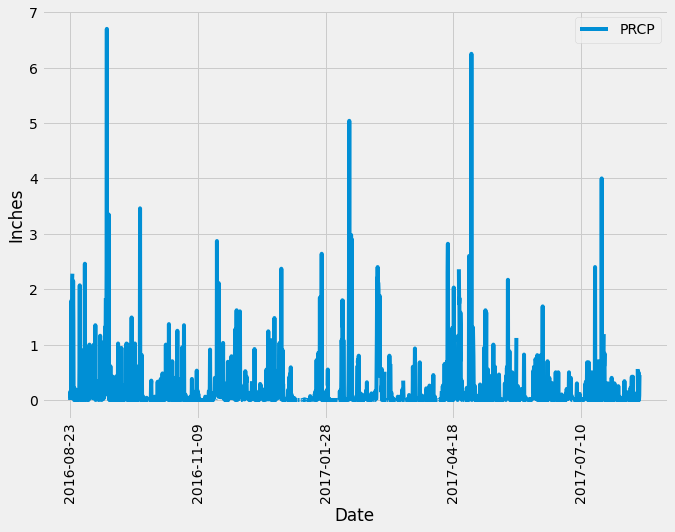

In [71]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(x="Date", y="PRCP", xlabel='Date', ylabel='Inches', rot=90, figsize=(10,7))
plt.legend(loc='upper right')
#plt.tight_layout()
plt.xticks()
plt.show()
#NEED TO FIX
#x-axis ticks are not complete; need title

In [26]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,PRCP
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [72]:
# Design a query to calculate the total number stations in the dataset
session.query(Station).count()

9

In [ ]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(Station.station, func.count(Measurement.station)).filter(Station.station == Measurement.station).group_by(Station.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [85]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
lowest = session.query(Measurement.tobs).filter(Measurement.station == "USC00519281").order_by(Measurement.tobs).first()
highest = session.query(Measurement.tobs).filter(Measurement.station == "USC00519281").order_by(Measurement.tobs.desc()).first()
avg = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281").first()

print(lowest)
print(highest)
print(avg)

(54.0,)
(85.0,)
(71.66378066378067,)


In [86]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_recentdate = session.query(Measurement.date).filter(Measurement.station == "USC00519281").order_by(Measurement.date.desc()).first().date
station_recentdate

'2017-08-18'

In [96]:
# calculating time delta using most recent date of 2017-08-18
new_query_date = dt.date(2017, 8, 18) - dt.timedelta(days=365)

station_year_data = session.query(Measurement).filter(Measurement.station == "USC00519281").filter(Measurement.date >= new_query_date).order_by(Measurement.date)
temperature_results = [{"Date": result.date, "Temperature": result.tobs} for result in station_year_data]
temperature_results

[{'Date': '2016-08-18', 'Temperature': 80.0},
 {'Date': '2016-08-19', 'Temperature': 79.0},
 {'Date': '2016-08-20', 'Temperature': 81.0},
 {'Date': '2016-08-21', 'Temperature': 79.0},
 {'Date': '2016-08-22', 'Temperature': 78.0},
 {'Date': '2016-08-23', 'Temperature': 77.0},
 {'Date': '2016-08-24', 'Temperature': 77.0},
 {'Date': '2016-08-25', 'Temperature': 80.0},
 {'Date': '2016-08-26', 'Temperature': 80.0},
 {'Date': '2016-08-27', 'Temperature': 75.0},
 {'Date': '2016-08-28', 'Temperature': 73.0},
 {'Date': '2016-08-29', 'Temperature': 78.0},
 {'Date': '2016-08-30', 'Temperature': 77.0},
 {'Date': '2016-08-31', 'Temperature': 78.0},
 {'Date': '2016-09-01', 'Temperature': 80.0},
 {'Date': '2016-09-02', 'Temperature': 80.0},
 {'Date': '2016-09-03', 'Temperature': 78.0},
 {'Date': '2016-09-04', 'Temperature': 78.0},
 {'Date': '2016-09-05', 'Temperature': 78.0},
 {'Date': '2016-09-06', 'Temperature': 73.0},
 {'Date': '2016-09-07', 'Temperature': 74.0},
 {'Date': '2016-09-08', 'Temperatu

In [97]:
station_df = pd.DataFrame(temperature_results)
station_df

,Date,Temperature
0,2016-08-18,80.0
1,2016-08-19,79.0
2,2016-08-20,81.0
3,2016-08-21,79.0
4,2016-08-22,78.0
...,...,...
352,2017-08-14,77.0
353,2017-08-15,77.0
354,2017-08-16,76.0
355,2017-08-17,76.0


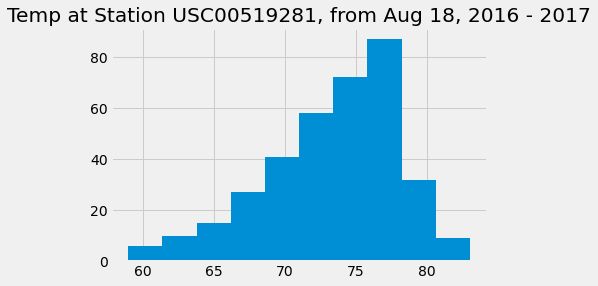

In [100]:
station_df.hist()
plt.title("Temp at Station USC00519281, from Aug 18, 2016 - 2017")
plt.show()

# Close session

In [101]:
# Close Session
session.close()